# Identifying safe loans with decision trees

The [LendingClub](https://www.lendingclub.com/) is a peer-to-peer leading company that directly connects borrowers and potential lenders/investors. In this notebook, you will build a classification model to predict whether or not a loan provided by LendingClub is likely to default.

In this notebook you will use data from the LendingClub to predict whether a loan will be paid off in full or the loan will be charged off and possibly go into default. In this assignment you will:

* Use pandas DataFrames and/or numpy arrays to do some feature engineering.
* Train a decision-tree on the LendingClub dataset.
* Visualize the tree.
* Predict whether a loan will default along with prediction probabilities (on a validation set).
* Train a complex tree model and compare it to simple tree model.

Let's get started!

In [1]:
from IPython.display import Image

In [2]:
import pandas as pd
import numpy as np

In [3]:
import ast

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz

In [5]:
import graphviz
import pydotplus

ImportError: No module named 'pydotplus'

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.charts import Histogram

# Load LendingClub dataset

We will be using a dataset from the [LendingClub](https://www.lendingclub.com/).

In [8]:
loans = pd.read_csv("./data/lending-club-data.csv", index_col=False)

C:\Users\Didier\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Exploring some features

Let's quickly explore what the dataset looks like. First, let's print out the column names to see what features we have in this dataset.

In [9]:
loans.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'not_compliant', 'status', 'inactive_loans', 'bad_loans',
       'emp_length_num', 'grade_num', 'sub_gra

Here, we see that we have some feature columns that have to do with grade of the loan, annual income, home ownership status, etc. Let's take a look at the distribution of loan grades in the dataset.

In [ ]:
pd.Series.to

In [39]:
l = loans.grade.value_counts().tolist()

In [42]:
l

[37172, 29950, 22314, 19175, 8990, 3932, 1074]

In [49]:
gr = pd.DataFrame(l, index=loans.grade.value_counts().index, columns=["grade"])

In [50]:
gr

,grade
B,37172
C,29950
A,22314
D,19175
E,8990
F,3932
G,1074


In [51]:
hist_loans = Histogram(gr,values="grade")
output_notebook()
show(hist_loans)

Loading BokehJS ...

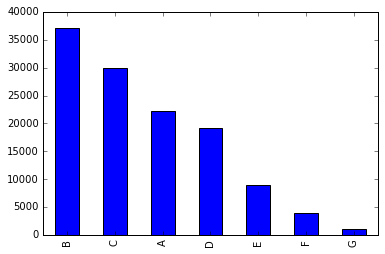

In [9]:
loans.grade.value_counts().plot(kind="bar")

We can see that over half of the loan grades are assigned values `B` or `C`. Each loan is assigned one of these grades, along with a more finely discretized feature called `sub_grade` (feel free to explore that feature column as well!). These values depend on the loan application and credit report, and determine the interest rate of the loan. More information can be found [here](https://www.lendingclub.com/public/rates-and-fees.action).

Now, let's look at a different feature.

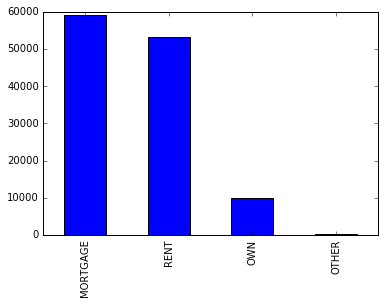

In [10]:
loans.home_ownership.value_counts().plot(kind="bar")

This feature describes whether the loanee is mortaging, renting, or owns a home. We can see that a small percentage of the loanees own a home.

## Exploring the target column

The target column (label column) of the dataset that we are interested in is called `bad_loans`. In this column **1** means a risky (bad) loan **0** means a safe  loan.

In order to make this more intuitive and consistent with the lectures, we reassign the target to be:
* **+1** as a safe  loan, 
* **-1** as a risky (bad) loan. 

We put this in a new column called `safe_loans`.

In [11]:
# safe_loans =  1 => safe
# safe_loans = -1 => risky
loans["safe_loans"] = loans["bad_loans"].apply(lambda x : +1 if x==0 else -1)

Now, let us explore the distribution of the column `safe_loans`. This gives us a sense of how many safe and risky loans are present in the dataset.

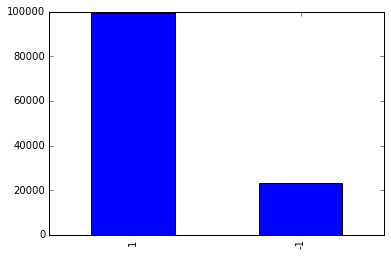

In [12]:
loans.safe_loans.value_counts().plot(kind="bar")

You should have:
* Around 81% safe loans
* Around 19% risky loans

It looks like most of these loans are safe loans (thankfully). But this does make our problem of identifying risky loans challenging.

## Features for the classification algorithm

In this assignment, we will be using a subset of features (categorical and numeric). The features we will be using are **described in the code comments** below. If you are a finance geek, the [LendingClub](https://www.lendingclub.com/) website has a lot more details about these features.

In [13]:
features = ["grade",                     # grade of the loan
            "sub_grade",                 # sub-grade of the loan
            "short_emp",                 # one year or less of employment
            "emp_length_num",            # number of years of employment
            "home_ownership",            # home_ownership status: own, mortgage or rent
            "dti",                       # debt to income ratio
            "purpose",                   # the purpose of the loan
            "term",                      # the term of the loan
            "last_delinq_none",          # has borrower had a delinquincy
            "last_major_derog_none",     # has borrower had 90 day or worse rating
            "revol_util",                # percent of available credit being used
            "total_rec_late_fee",        # total late fees received to day
           ]

target = "safe_loans"                    # prediction target (y) (+1 means safe, -1 is risky)

# Extract the feature columns and target column
loans = loans[features + [target]]

What remains now is a **subset of features** and the **target** that we will use for the rest of this notebook. 

## Sample data to balance classes

As we explored above, our data is disproportionally full of safe loans.  Let's create two datasets: one with just the safe loans (`safe_loans_raw`) and one with just the risky loans (`risky_loans_raw`).

**This step not to be done as the index files we're downloading when not using SFrame already take care of class imbalance**

**Note:** There are many approaches for dealing with imbalanced data, including some where we modify the learning algorithm. These approaches are beyond the scope of this course, but some of them are reviewed in this [paper](http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=5128907&url=http%3A%2F%2Fieeexplore.ieee.org%2Fiel5%2F69%2F5173046%2F05128907.pdf%3Farnumber%3D5128907 ). For this assignment, we use the simplest possible approach, where we subsample the overly represented class to get a more balanced dataset. In general, and especially when the data is highly imbalanced, we recommend using more advanced methods.

## Transform categorical data
We will transform categorical data using **pandas.get_dummies**.

In [14]:
loans = pd.get_dummies(loans)

In [15]:
loans.head(5)

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
0,0,11,27.65,1,1,83.7,0.00,1,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,1,1.00,1,1,9.4,0.00,-1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,11,8.72,1,1,98.5,0.00,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,0,11,20.00,0,1,21.0,16.97,1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,4,11.20,1,1,28.3,0.00,1,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


## Download training and validation sets

**Note**: In previous assignments, we have called this a **train-test split**. However, the portion of data that we don't train on will be used to help **select model parameters** (this is known as model selection). Thus, this portion of data should be called a **validation set**. Recall that examining performance of various potential models (i.e. models with different parameters) should be on validation set, while evaluation of the final selected model should always be on test data. Typically, we would also save a portion of the data (a real test set) to test our final model on or use cross-validation on the training set to select our final model. But for the learning purposes of this assignment, we won't do that.

In [16]:
f = open("./data/module-5-assignment-1-train-idx.json")
train_data_index = f.readline()
f.close()

# Transform the read string into a list
train_data_index = ast.literal_eval(train_data_index)

train_data = loans.loc[train_data_index]

In [17]:
f = open("./data/module-5-assignment-1-validation-idx.json")
validation_data_index = f.readline()
f.close()

# Transform the read string into a list
validation_data_index = ast.literal_eval(validation_data_index)

validation_data = loans.loc[validation_data_index]

# Use decision tree to build a classifier

Now, let's use the built-in **SciKit-Learn** decision tree learner to create a loan prediction model on the training data. (In the next assignment, you will implement your own decision tree learning algorithm). Our feature columns and target column have already been decided above.

## Rename `features`
This is because we've created more features (columns) when doing hot encoding. We get the list of columns from the loans created after having transformed categorical data and remove `safe_loans` from it. 

In [18]:
features = loans.columns.tolist()
features.remove("safe_loans")

## Build classifier

In [19]:
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(train_data[features], train_data[target])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

## Also build a classifier with depth=6
As it is said below that this is the default for Graplab decision tree. That's therefore important to get the same results for the Quiz.

In [20]:
decision_tree_model_depth6 = DecisionTreeClassifier(max_depth=6)
decision_tree_model_depth6.fit(train_data[features], train_data[target])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

## Visualizing a learned model

As noted in the [documentation](https://dato.com/products/create/docs/generated/graphlab.boosted_trees_classifier.create.html#graphlab.boosted_trees_classifier.create), typically the max depth of the tree is capped at 6. However, such a tree can be hard to visualize graphically.  Here, we instead learn a smaller model with **max depth of 2** to gain some intuition by visualizing the learned tree.

In [21]:
small_model = DecisionTreeClassifier(max_depth=2)
small_model.fit(train_data[features], train_data[target])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [22]:
export_graphviz(small_model, out_file="mytree.dot")

In [23]:
with open("./mytree.dot") as f:
    dot_graph = f.read()
graph = pydotplus.graph_from_dot_data(dot_graph)

In [24]:
Image(graph.create_png())

InvocationException: GraphViz's executables not found

In [64]:
graph = pydotplus.graph_from_dot_data(dot_data)

TypeError: object of type '_io.StringIO' has no len()

In [25]:
with open("./mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

RuntimeError: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' path

In the view that is provided by GraphLab Create, you can see each node, and each split at each node. This visualization is great for considering what happens when this model predicts the target of a new data point. 

**Note:** To better understand this visual:
* The root node is represented using pink. 
* Intermediate nodes are in green. 
* Leaf nodes in blue and orange. 

In [ ]:
small_model.show(view="Tree")

# Making predictions

Let's consider two positive and two negative examples **from the validation set** and see what the model predicts. We will do the following:
* Predict whether or not a loan is safe.
* Predict the probability that a loan is safe.

In [22]:
validation_safe_loans = validation_data[validation_data[target] == 1]
validation_risky_loans = validation_data[validation_data[target] == -1]

sample_validation_data_risky = validation_risky_loans[0:2]
sample_validation_data_safe = validation_safe_loans[0:2]

sample_validation_data = sample_validation_data_safe.append(sample_validation_data_risky)
sample_validation_data

,short_emp,emp_length_num,dti,last_delinq_none,last_major_derog_none,revol_util,total_rec_late_fee,safe_loans,grade_A,grade_B,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,purpose_vacation,purpose_wedding,term_ 36 months,term_ 60 months
19,0,11,11.18,1,1,82.4,0.0,1,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
79,0,10,16.85,1,1,96.4,0.0,1,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
24,0,3,13.97,0,1,59.5,0.0,-1,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
41,0,11,16.33,1,1,62.1,0.0,-1,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Explore label predictions

Now, we will use our model  to predict whether or not a loan is likely to default. For each row in the **sample_validation_data**, use the **decision_tree_model** to predict whether or not the loan is classified as a **safe loan**. 

**Hint:** Be sure to use the `.predict()` method.

In [23]:
predict_decision_tree_model = decision_tree_model.predict(sample_validation_data[features])
predict_decision_tree_model_depth6 = decision_tree_model_depth6.predict(sample_validation_data[features])

**Quiz Question:** What percentage of the predictions on `sample_validation_data` did `decision_tree_model` get correct?

In [24]:
print("predict_decision_tree_model:       ",predict_decision_tree_model)
print("predict_decision_tree_model_depth6:",predict_decision_tree_model_depth6)

predict_decision_tree_model:        [ 1 -1  1  1]
predict_decision_tree_model_depth6: [ 1 -1 -1  1]


**Quiz Response:** predict_decision_tree_model_depth6 give 2 over 4 predictions is correct, i.e. 50%

## Explore probability predictions

For each row in the **sample_validation_data**, what is the probability (according **decision_tree_model**) of a loan being classified as **safe**? 


**Hint:** Set `output_type='probability'` to make **probability** predictions using **decision_tree_model** on `sample_validation_data`:

In [25]:
predict_proba_decision_tree_model = decision_tree_model.predict_proba(sample_validation_data[features])
predict_proba_decision_tree_model_depth6 = decision_tree_model_depth6.predict_proba(sample_validation_data[features])

**Quiz Question:** Which loan has the highest probability of being classified as a **safe loan**?

**Checkpoint:** Can you verify that for all the predictions with `probability >= 0.5`, the model predicted the label **+1**?

In [26]:
print("predict_proba_decision_tree_model:")
print(predict_proba_decision_tree_model)
print("predict_proba_decision_tree_model_depth6")
print(predict_proba_decision_tree_model_depth6)

predict_proba_decision_tree_model:
[[ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]]
predict_proba_decision_tree_model_depth6
[[ 0.34156543  0.65843457]
 [ 0.53630646  0.46369354]
 [ 0.64750958  0.35249042]
 [ 0.20789474  0.79210526]]


**Quiz Response:** The 4th one: sample_validation_data[3]

### Tricky predictions!

Now, we will explore something pretty interesting. For each row in the **sample_validation_data**, what is the probability (according to **small_model**) of a loan being classified as **safe**?

**Hint:** Set `output_type='probability'` to make **probability** predictions using **small_model** on `sample_validation_data`:

In [27]:
predict_proba_small_model = small_model.predict_proba(sample_validation_data[features])

In [28]:
print("predict_proba_small_model:")
print(predict_proba_small_model)

predict_proba_small_model:
[[ 0.41896585  0.58103415]
 [ 0.59255339  0.40744661]
 [ 0.59255339  0.40744661]
 [ 0.23120112  0.76879888]]


**Quiz Question:** Notice that the probability preditions are the **exact same** for the 2nd and 3rd loans. Why would this happen?

**Quiz Response**: They fall in the same leaf node.

## Visualize the prediction on a tree


Note that you should be able to look at the small tree, traverse it yourself, and visualize the prediction being made. Consider the following point in the **sample_validation_data**

In [ ]:
sample_validation_data[1]

Let's visualize the small tree here to do the traversing for this data point.

In [ ]:
small_model.show(view="Tree")

**Note:** In the tree visualization above, the values at the leaf nodes are not class predictions but scores (a slightly advanced concept that is out of the scope of this course). You can read more about this [here](https://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf).  If the score is $\geq$ 0, the class +1 is predicted.  Otherwise, if the score < 0, we predict class -1.


**Quiz Question:** Based on the visualized tree, what prediction would you make for this data point?

Now, let's verify your prediction by examining the prediction made using GraphLab Create.  Use the `.predict` function on `small_model`.

# Evaluating accuracy of the decision tree model

Recall that the accuracy is defined as follows:
$$
\mbox{accuracy} = \frac{\mbox{# correctly classified examples}}{\mbox{# total examples}}
$$

Let us start by evaluating the accuracy of the `small_model` and `decision_tree_model` on the training data

In [29]:
predict_train_small_model = small_model.predict(train_data[features])
accuracy_train_small_model = accuracy_score(train_data[target],predict_train_small_model)
print("accuracy_train_small_model:",accuracy_train_small_model)
print("accuracy_train_small_model:",small_model.score(train_data[features],train_data[target]))

accuracy_train_small_model: 0.613502041694
accuracy_train_small_model: 0.613502041694


In [35]:
accuracy_train_decision_tree_model_depth6 = decision_tree_model_depth6.score(train_data[features],train_data[target])
print("accuracy_train_decision_tree_model_depth6:",accuracy_train_decision_tree_model_depth6)
print("accuracy_train_decision_tree_model_depth6:",round(accuracy_train_decision_tree_model_depth6,2))

accuracy_train_decision_tree_model_depth6: 0.640527616591
accuracy_train_decision_tree_model_depth6: 0.64


**Checkpoint:** You should see that the **small_model** performs worse than the **decision_tree_model** on the training data.


Now, let us evaluate the accuracy of the **small_model** and **decision_tree_model** on the entire **validation_data**, not just the subsample considered above.

In [36]:
accuracy_validation_small_model = small_model.score(validation_data[features],validation_data[target])
accuracy_validation_decision_tree_model_depth6 = decision_tree_model_depth6.score(validation_data[features],
                                                                                  validation_data[target])
print("accuracy_validation_small_model:               ",round(accuracy_validation_small_model,2))
print("accuracy_validation_decision_tree_model_depth6:",accuracy_validation_decision_tree_model_depth6)
print("accuracy_validation_decision_tree_model_depth6:",round(accuracy_validation_decision_tree_model_depth6,2))

accuracy_validation_small_model:                0.62
accuracy_validation_decision_tree_model_depth6: 0.636148211978
accuracy_validation_decision_tree_model_depth6: 0.64


**Quiz Question:** What is the accuracy of `decision_tree_model` on the validation set, rounded to the nearest .01?

**Quiz Response**: 0.64

## Evaluating accuracy of a complex decision tree model

Here, we will train a large decision tree with `max_depth=10`. This will allow the learned tree to become very deep, and result in a very complex model. Recall that in lecture, we prefer simpler models with similar predictive power. This will be an example of a more complicated model which has similar predictive power, i.e. something we don't want.

In [37]:
big_model = DecisionTreeClassifier(max_depth=10)
big_model.fit(train_data[features], train_data[target])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

Now, let us evaluate **big_model** on the training set and validation set.

In [38]:
print("big_model accuracy (train):", big_model.score(train_data[features],train_data[target]))
print("big_model accuracy (validation):", big_model.score(validation_data[features],validation_data[target]))

big_model accuracy (train): 0.66379217709
big_model accuracy (validation): 0.626130978027


**Checkpoint:** We should see that **big_model** has even better performance on the training set than **decision_tree_model** did on the training set.

**Quiz Question:** How does the performance of **big_model** on the validation set compare to **decision_tree_model** on the validation set? Is this a sign of overfitting?

**Quiz Response**: Perform worse on validation set, it is a sign of overfitting (as it performs better on training set).

### Quantifying the cost of mistakes

Every mistake the model makes costs money. In this section, we will try and quantify the cost of each mistake made by the model.

Assume the following:

* **False negatives**: Loans that were actually safe but were predicted to be risky. This results in an oppurtunity cost of losing a loan that would have otherwise been accepted. 
* **False positives**: Loans that were actually risky but were predicted to be safe. These are much more expensive because it results in a risky loan being given. 
* **Correct predictions**: All correct predictions don't typically incur any cost.


Let's write code that can compute the cost of mistakes made by the model. Complete the following 4 steps:
1. First, let us compute the predictions made by the model.
1. Second, compute the number of false positives.
2. Third, compute the number of false negatives.
3. Finally, compute the cost of mistakes made by the model by adding up the costs of true positives and false positives.

First, let us make predictions on `validation_data` using the `decision_tree_model`:

In [40]:
predictions = decision_tree_model_depth6.predict(validation_data[features])

Let's compute the **confusion matrix**

In binary classification, the count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}.

In [69]:
cm = confusion_matrix(np.array(validation_data[target]),predictions)

In [70]:
cm

array([[3013, 1661],
       [1717, 2893]])

**False positives** are predictions where the model predicts +1 but the true label is -1. Complete the following code block for the number of false positives:

In [76]:
false_positives = cm[0,1]
print("False positives:",false_positives)

False positives: 1661


**False negatives** are predictions where the model predicts -1 but the true label is +1. Complete the following code block for the number of false negatives:

In [77]:
false_negatives = cm[1,0]
print("False negatives:",false_negatives)

False negatives: 1717


**Quiz Question:** Let us assume that each mistake costs money:
* Assume a cost of \$10,000 per false negative.
* Assume a cost of \$20,000 per false positive.

What is the total cost of mistakes made by `decision_tree_model` on `validation_data`?

In [78]:
total_cost = false_negatives * 10000 + false_positives * 20000
print("total_cost:", total_cost)

total_cost: 50390000
